# More About Monitor 

In BrainPy, each object (any instance of `brainpy.DynamicalSystem`) has the inherent monitor. Users can set up the monitor when initializing the brain objects. For example, if you have the following `HH` neuron model,

In [1]:
import sys
sys.path.append('../../')
import brainpy as bp

In [2]:
class HH(bp.NeuGroup):
  def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
               C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
               **kwargs):
    super(HH, self).__init__(size=size, **kwargs)

    # parameters
    self.ENa = ENa
    self.EK = EK
    self.EL = EL
    self.C = C
    self.gNa = gNa
    self.gK = gK
    self.gL = gL
    self.V_th = V_th

    # variables
    self.V = bp.math.Variable(bp.math.ones(self.num) * -65.)
    self.m = bp.math.Variable(bp.math.ones(self.num) * 0.5)
    self.h = bp.math.Variable(bp.math.ones(self.num) * 0.6)
    self.n = bp.math.Variable(bp.math.ones(self.num) * 0.32)
    self.input = bp.math.Variable(bp.math.zeros(self.num))
    self.spike = bp.math.Variable(bp.math.zeros(self.num, dtype=bool))

  @bp.odeint(method='exponential_euler')
  def integral(self, V, m, h, n, t, Iext):
    alpha = 0.1 * (V + 40) / (1 - bp.math.exp(-(V + 40) / 10))
    beta = 4.0 * bp.math.exp(-(V + 65) / 18)
    dmdt = alpha * (1 - m) - beta * m

    alpha = 0.07 * bp.math.exp(-(V + 65) / 20.)
    beta = 1 / (1 + bp.math.exp(-(V + 35) / 10))
    dhdt = alpha * (1 - h) - beta * h

    alpha = 0.01 * (V + 55) / (1 - bp.math.exp(-(V + 55) / 10))
    beta = 0.125 * bp.math.exp(-(V + 65) / 80)
    dndt = alpha * (1 - n) - beta * n

    I_Na = (self.gNa * m ** 3 * h) * (V - self.ENa)
    I_K = (self.gK * n ** 4) * (V - self.EK)
    I_leak = self.gL * (V - self.EL)
    dVdt = (- I_Na - I_K - I_leak + Iext) / self.C

    return dVdt, dmdt, dhdt, dndt

  def update(self, _t, _i):
    V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t, self.input)
    self.spike[:] = bp.math.logical_and(self.V < self.V_th, V >= self.V_th)
    self.V[:] = V
    self.m[:] = m
    self.h[:] = h
    self.n[:] = n
    self.input[:] = 0

the monitor can be set up when users create a `HH` neuron group:

In [3]:
# set up a monitor using a list/tuple of strings
group1 = HH(size=10, monitors=['V', 'spike'])

type(group1.mon)

brainpy.simulation.monitor.Monitor

In [4]:
# set up a monitor using the Monitor class
group2 = HH(size=10, monitors=bp.Monitor(variables=['V', 'spike']))

Once we run the given model/network, the monitors will record the evolution of variables in the corresponding neural or synaptic models. 

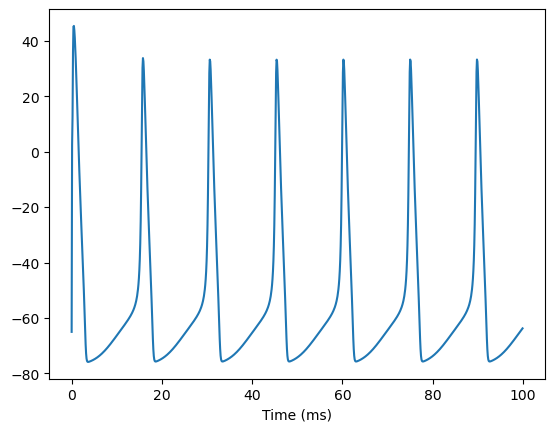

In [5]:
group1.run(100., inputs=('input', 10))

bp.visualize.line_plot(group1.mon.ts, group1.mon.V, show=True)

## Monitor variables at the selected index

However, we do not always take care of the all the content in a variable. We may be only interested in the values at the selected index. Moreover, for huge networks and long simulations, monitors will be a big part to consume RAM. Monitoring variables only at the selected index is a good solution. For these scenarios, we can initialize the monitors with the format of tuple/dict like this:

In [6]:
group3 = HH(
  size=10,
  monitors=['V', ('spike', [1, 2, 3])]  # use a tuple to specify the (key, index)
)

group3.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" is (run length, variable size) = {group3.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {group3.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (1000, 10)
The monitor shape of "spike" is (run length, index size) = (1000, 3)


Or, use a dictionary to specify the interested index of the variable:

In [7]:
group4 = HH(
  size=10,
  monitors={'V': None, 'spike': [1, 2, 3]}  # use a dict to specify the {key: index}
)

group4.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" is (run length, variable size) = {group4.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {group4.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (1000, 10)
The monitor shape of "spike" is (run length, index size) = (1000, 3)


Also, an instance of `Monitor` class can also be used:

In [8]:
group5 = HH(
  size=10,
  # monitors=bp.simulation.Monitor(variables=['V', ('spike', [1, 2, 3])])
  monitors=bp.Monitor(variables={'V': None, 'spike': [1, 2, 3]})  # initialize a Monitor
  # to specify the key-index
)

group5.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" is (run length, variable size) = {group5.mon.V.shape}')
print(f'The monitor shape of "spike" is (run length, index size) = {group5.mon.spike.shape}')

The monitor shape of "V" is (run length, variable size) = (1000, 10)
The monitor shape of "spike" is (run length, index size) = (1000, 3)


## Monitor variables with customized period

In long simulations with small `dt` time step, what we take care about is the trend of the variable evolution, not the exact values at each time point (especially when `dt` is very small). For this scenario, we can initializing the monitors with the `every` item specification (similar to the decorator `@brainpy.every(time=...)`):

In [9]:
group6 = HH(
  size=10,
  monitors=bp.simulation.Monitor(variables={'V': None, 'spike': [1, 2, 3]},
                                 intervals={'V': None, 'spike': 1.})
)

In this example, we monitor "spike" variables at the index of [1, 2, 3] for each `1 ms`. 

In [10]:
group6.run(100., inputs=('input', 10.))

print(f'The monitor shape of "V" = {group6.mon.V.shape}')
print(f'The monitor shape of "spike" = {group6.mon.spike.shape}')

The monitor shape of "V" = (1000, 10)
The monitor shape of "spike" = (100, 3)


But what is different from the decorator `@brainpy.every(time=...)` is that the `time` can not receive a bool function. This is because the monitors will allocate the data need to record in advance. But the bool function makes the beforehand allocation more difficult. 

---

**Author**:

- Chaoming Wang
- Email: adaduo@outlook.com
- Date: 2021.05.24

---